<a href="https://colab.research.google.com/github/WahomeKezia/Image_Classification/blob/main/TeaLeaves_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Runtime: CPU

In [3]:
#Import TensorFlow and other necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive  # To mount Google Drive
import os
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


The dataset contains 7 sub-directories
of  common diseases of tea:
The dataset further contains a class of healthy tea leaves.  Each of the classes contains more than 100 images.
```
teasicknessdataset/
   healthy/
   algal leaf /
   bird eye spot/
   gray light/
   Anthracnose/
   white spot/
   red leaf spot/
   brown blight/

```





#Mount Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

#Upload and explore the dataset

In [44]:
# Import necessary libraries
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/Image_Classification/teasicknessdataset'

# Create a list to store the subdirectories (class names) in your dataset
class_names = []

# Walk through the dataset directory and retrieve subdirectories
for x in os.walk(dataset_path):
    # Get the current subdirectory path
    sub_dir = x[0]

    # Split the subdirectory path based on '/'
    sub_dir_list = str(sub_dir).split('/')

    # Check if the subdirectory is a class (based on its depth in the directory structure)
    if len(sub_dir_list) > 4:
        # Extract the class name from the subdirectory path
        x_class = sub_dir_list[-1]

        # Append the class name to the list
        class_names.append(x_class)

# Print the list of class names
print(class_names)



['teasicknessdataset', 'healthy', 'algal leaf', 'bird eye spot', 'gray light', 'Anthracnose', 'white spot', 'red leaf spot', 'brown blight']


In [45]:
from pathlib import Path

# Assuming 'dataset_path' is the root path of your dataset
dataset_dir = Path(dataset_path)

# Print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:", image_count)

Images in class teasicknessdataset: 0
Images in class healthy: 74
Images in class algal leaf: 113
Images in class bird eye spot: 100
Images in class gray light: 100
Images in class Anthracnose: 100
Images in class white spot: 142
Images in class red leaf spot: 143
Images in class brown blight: 113


#Preprocessing using ImageDataGenerator before splitting the data:

using ImageDataGenerator for online data augmentation and normalization before splitting the data,

In [46]:
#Normalization using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values to be between 0 and 1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create a data generator for training images
batch_size = 32
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),   # Adjust size based on your model's preferred input size (if not using a pre-trained model)
    batch_size=batch_size,
    class_mode='categorical'  # sets multiple classes (categorical classification)
)


Found 885 images belonging to 8 classes.


<Figure size 1000x500 with 0 Axes>

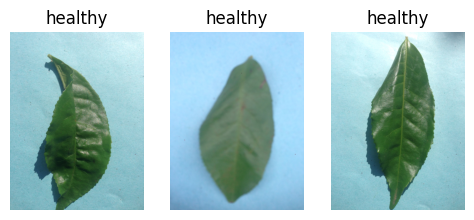

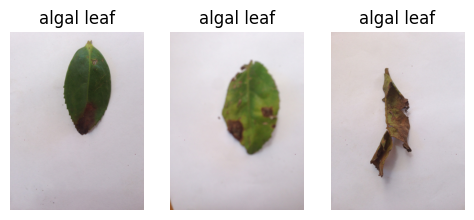

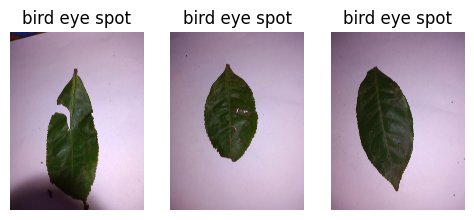

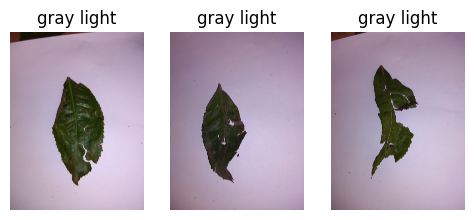

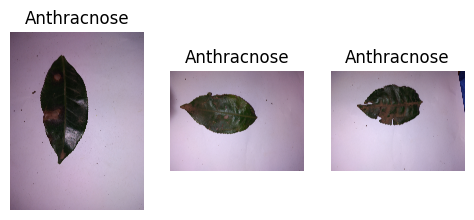

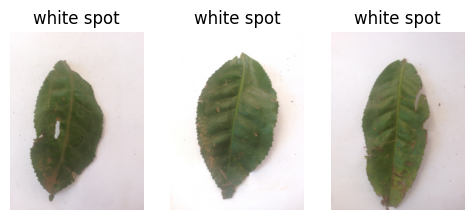

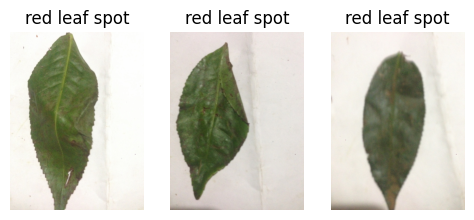

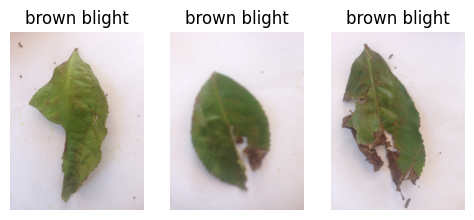

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Visualize sample images
for class_i in class_names:
    # Get a list of paths to 3 sample images for the current class
    sample_images = list(dataset_dir.glob(f'{class_i}/*.jpg'))[:3]

    # Create a figure to display the sample images
    plt.figure(figsize=(10, 5))

    # Loop through the sample images and display them
    for i, img_path in enumerate(sample_images):
        # Create a subplot for each image
        plt.subplot(1, 5, i + 1)

        # Open the image using PIL
        img = Image.open(str(img_path))

        # Display the image
        plt.imshow(img)

        # Set the title of the subplot as the class name
        plt.title(class_i)

        # Turn off axis labels
        plt.axis('off')

    # Show the figure with the sample images for the current class
    plt.show()


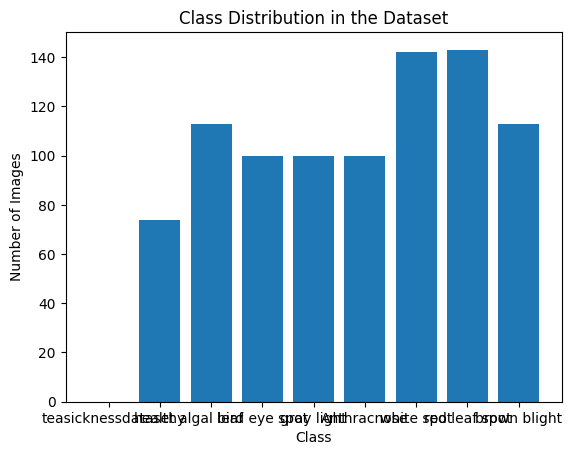

In [ ]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.bar(class_names, [len(list(dataset_dir.glob(f'{class_i}/*.jpg'))) for class_i in class_names])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.show()


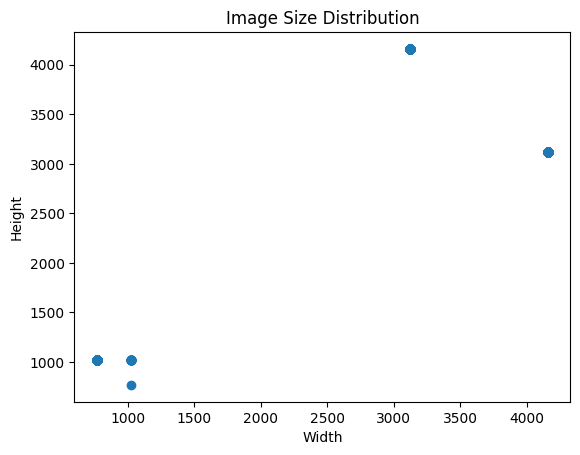

In [ ]:
import matplotlib.pyplot as plt

# Plot image size distribution
image_sizes = [Image.open(str(img_path)).size for img_path in dataset_dir.glob('*/*.jpg')]
widths, heights = zip(*image_sizes)
plt.scatter(widths, heights)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.show()


#Load data using a Keras utility

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the Load and preprocess images tutorial.


1.Create a dataset

In [47]:
# Parameter setting
train_batch = 128   # Batch size for training
val_batch = 128     # Batch size for validation
img_height = 224    # Target height for resizing images
img_width = 224     # Target width for resizing images
IMG_SIZE = (img_height, img_width)  # Tuple representing the target size for images
val_split = 0.2     # Validation split ratio (20% of the data will be used for validation)




It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

Using the image_dataset_from_directory function from TensorFlow to load the training dataset.

In [48]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,               # Path to the directory containing the dataset
    validation_split=val_split, # Percentage of data to use for validation
    subset="training",          # Specify that this is the training dataset
    seed=123,                   # Seed for reproducibility
    image_size=(img_height, img_width),  # Target size for resizing images
    batch_size=train_batch      # Batch size for training
)

Found 885 files belonging to 8 classes.
Using 708 files for training.


Loading the data for validation using the image_dataset_from_directory function

In [49]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,               # Path to the directory containing the dataset
    validation_split=val_split, # Percentage of data to use for validation
    subset="validation",        # Specify that this is the validation dataset
    seed=123,                   # Seed for reproducibility
    image_size=(img_height, img_width),  # Target size for resizing images
    batch_size=val_batch        # Batch size for validation
)

Found 885 files belonging to 8 classes.
Using 177 files for validation.


Retrieving the class names from the training dataset and printing them .These correspond to the directory names in alphabetical order.

In [50]:
# Get class names from the training dataset
class_names = train_ds.class_names

# Print the class names
print(class_names)

# Determine the number of classes
num_classes = len(class_names)


['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


#Visualize the data
Here are the first nine images from the training dataset:
This ensures that the images and labels are correctly loaded and that the dataset is well-prepared for training

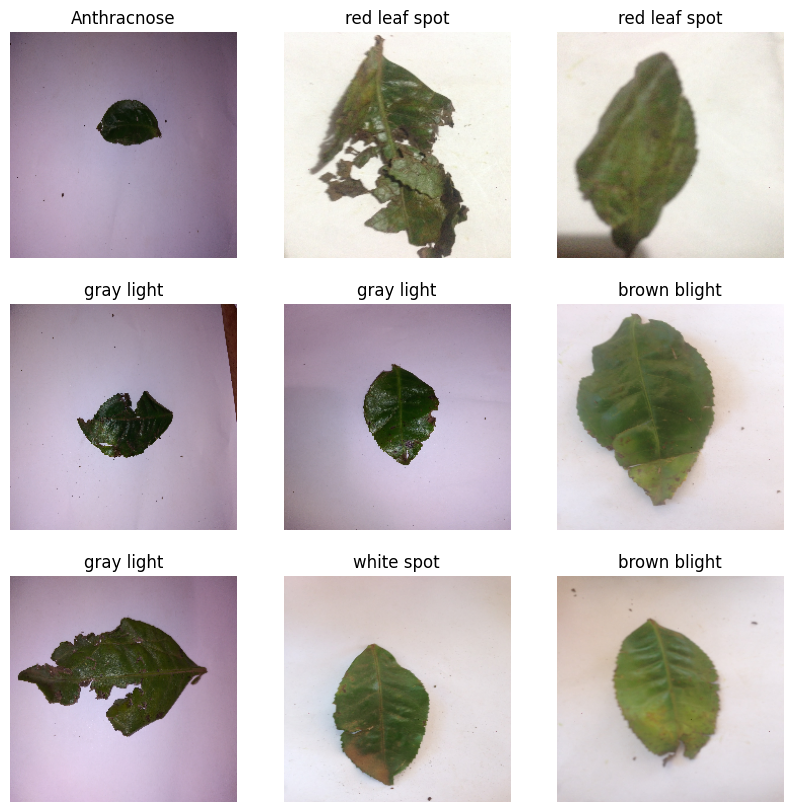

In [51]:
# Review dataset sample
plt.figure(figsize=(10, 10))

# Iterate over the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Display a 3x3 grid of images
    for i in range(9):
        # Create a subplot for each image
        ax = plt.subplot(3, 3, i + 1)

        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot as the class name
        plt.title(class_names[labels[i]])

        # Turn off axis labels for better visualization
        plt.axis("off")




checking the shapes of the image and label batches in your training dataset.

Manually passing these dataset to the Keras `Model.fit` method for training by iterating over the dataset and retrieving batches of images:


In [52]:
# Iterate over batches in the training dataset and print batch shapes
for image_batch, labels_batch in train_ds:
    # Print the shape of the current image batch
    print("Image batch shape:", image_batch.shape)

    # Print the shape of the current labels batch
    print("Labels batch shape:", labels_batch.shape)

    # Break the loop after processing the first batch
    break


Image batch shape: (128, 224, 224, 3)
Labels batch shape: (128,)


The image_batch is a tensor of the shape `(128, 224, 224, 3)`. This is a batch of `128` images of shape `224x224x3` (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape `(128,)`, these are corresponding labels to the 128 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

# Preprocessing using TensorFlow's map function after splitting the data


1. Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

# Apply caching, shuffling, and prefetching to the training dataset
train_ds = train_ds.cache()       # Cache the dataset for improved performance
train_ds = train_ds.shuffle(1000) # Shuffle the dataset for randomness during training
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch batches for smoother training

# Apply caching and prefetching to the validation dataset
val_ds = val_ds.cache()           # Cache the dataset for improved performance
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch batches for smoother validation


NameError: ignored

#Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make the input values small.

This step is essential for preparing the input data for the model. Normalizing pixel values helps in stabilizing the training process and allows the model to converge more efficiently

Here, I will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



In [54]:
# Define a Rescaling layer to normalize pixel values
normalization_layer = layers.Rescaling(1./255)

In [1]:
# Apply normalization to the entire training dataset using the map function
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Retrieve a batch of normalized images and labels
image_batch, labels_batch = next(iter(normalized_ds))

# Extract the first normalized image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first normalized image
print("Min pixel value:", np.min(first_image))
print("Max pixel value:", np.max(first_image))

NameError: ignored

#Build Model

 incorporating data augmentation into my  model, which is an excellent practice to increase the diversity of your training dataset and improve the generalization in the model

In [ ]:
# Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [ ]:
# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Model architecture
model = Sequential([
    # Data augmentation layers
    data_augmentation,

    # Rescale pixel values to be in the [0,1] range
    layers.Rescaling(1./255),

    # Convolutional layers with max pooling
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Flatten the output for dense layers
    layers.Flatten(),

    # Dense layers with dropout and batch normalization
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Output layer with the number of classes
    layers.Dense(num_classes)
])


#Compile the model
To compile the model choose the` tf.keras.optimizers.Adam optimizer` and `tf.keras.losses.SparseCategoricalCrossentropy` loss function.
To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile.`

In [ ]:
# compile model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

After running this code, the output is a table with detailed information about each layer in the model, including the number of parameters. This can be helpful for debugging and optimizing your model architecture.





In [ ]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                 

#Train the model
Train the model for 320 epochs with the Keras `model.fit` method:

In [ ]:
# Train the model with detailed comments and progress updates
epochs = 500

# Start training the model
history = model.fit(
    train_ds,                   # Training dataset
    validation_data=val_ds,     # Validation dataset for evaluation during training
    epochs=epochs,              # Number of training epochs
    verbose=2                # Set to 1 for detailed progress updates during training
)

# Save the entire model to a HDF5 file
model.save('/content/drive/MyDrive/Image_Classification/tea_leaf_disease_model.h5')



#Visualize training results
Visualizations of training and validation accuracy as well as training and validation loss over the specified number of epochs.

Create plots of the loss and accuracy on the training and validation sets:

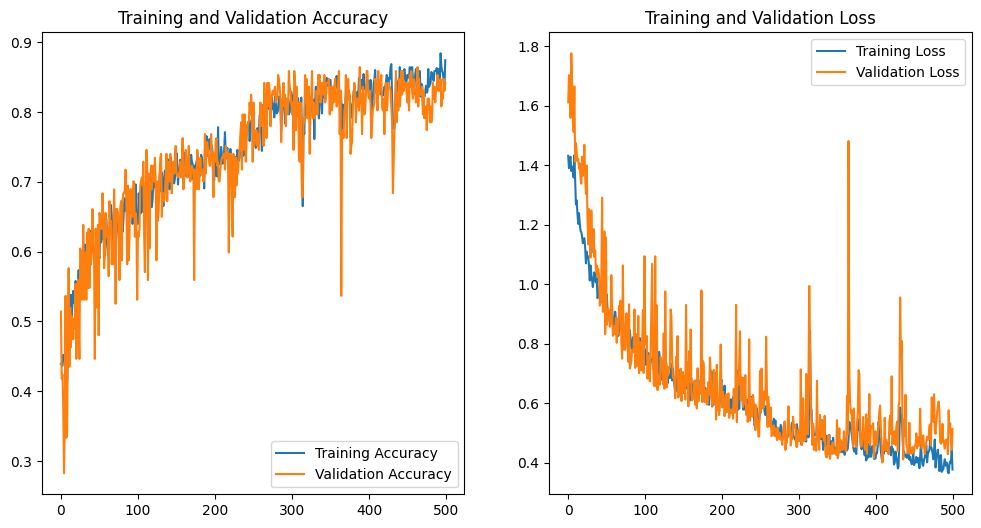

In [ ]:
# Check training result with visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()


#Evaluate Model
a comprehensive evaluation of the model's performance on a batch of validation data, including detailed metrics and visualizations.

Predictions:
 [7 7 0 7 2 7 0 1 1 4 4 3 7 6 0 1 0 3 3 4 3 0 6 3 7 4 1 1 4 0 3 5 3 0 6 4 3
 1 4 4 7 3 6 4 0 4 6 3 1 7 6 0 3 4 4 7 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 0
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 7 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 4]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3
 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.70      0.78      0.74        18
           1       0.93      1.00      0.96        13
           2       0.83      0.45      0.59        11
           3       0.83      0.83      0.83        23
           4       0.83      0.95      0.88        20
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        15
           7       0.

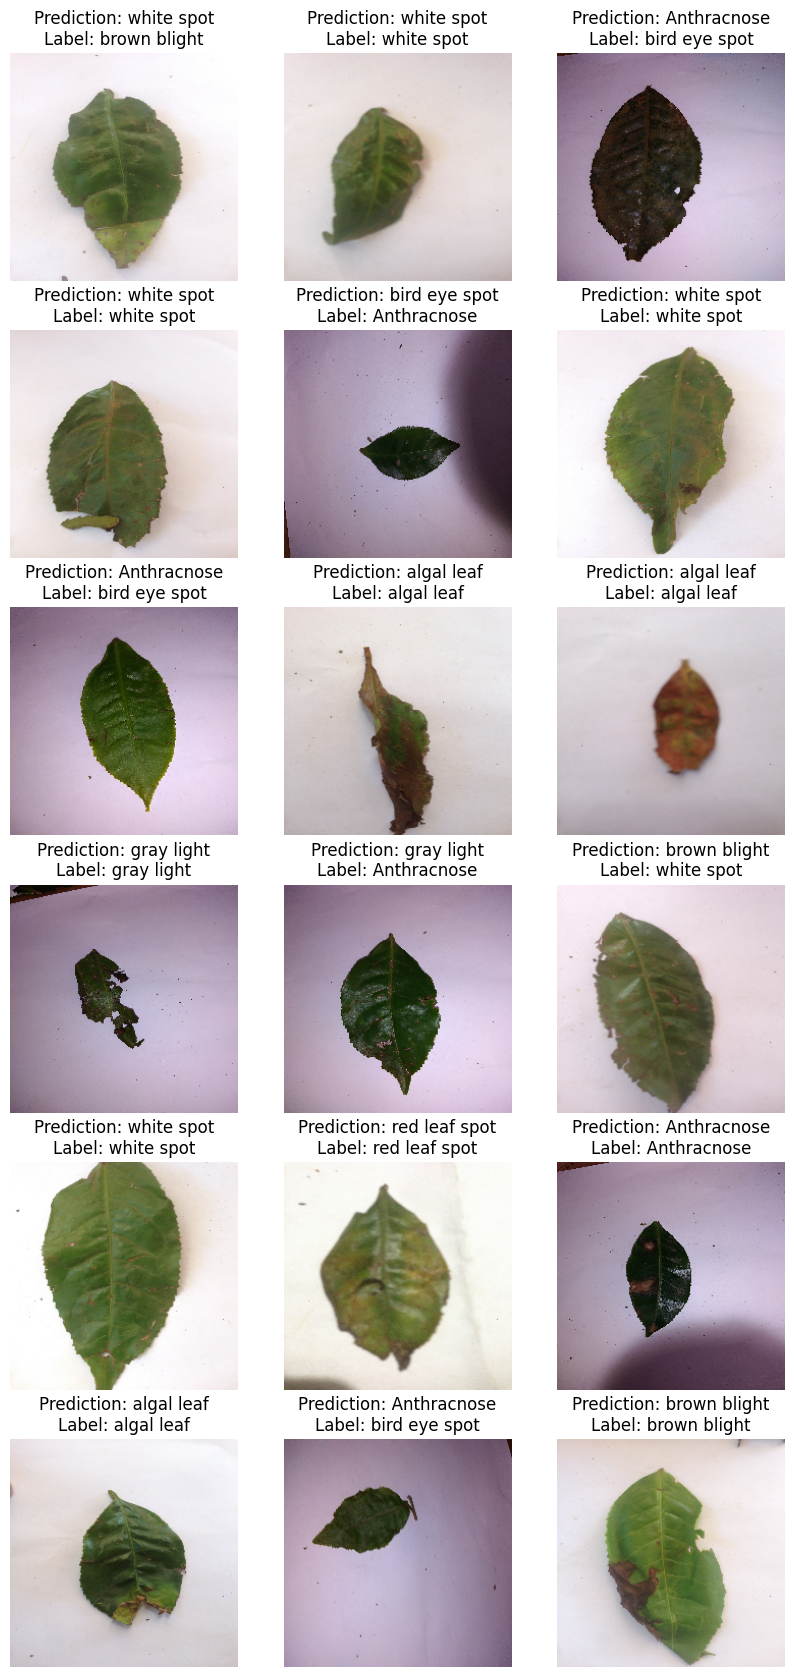

In [ ]:
# Retrieve a batch of images from the test set
from sklearn.metrics import classification_report

image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")


#Save Model History


In [ ]:
# Create a DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Save the training history to a CSV file
history_df.to_csv("history.csv")

# Display the last few entries of the training history
history_df.tail()


loss  accuracy  val_loss  val_accuracy
495  0.392273  0.858757  0.506145      0.824859
496  0.405238  0.855932  0.533208      0.819209
497  0.402010  0.844633  0.472114      0.847458
498  0.445757  0.836158  0.444086      0.830508
499  0.377715  0.874294  0.514163      0.841808

#Alterntive Two :Using Pretrained model
using a pre-trained VGG16 model as a feature extractor.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer to reduce the spatial dimensions of the output
x = GlobalAveragePooling2D()(base_model.output)

# Create a new model with the added pooling layer
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Display the summary of the feature extraction model
feature_extractor.summary()


#Deploying the Model using Gradio

In [ ]:
# Install the required versions of dependencies
!pip install typing-extensions==3.10.0.0
!pip install tensorflow-probability==0.22.0  # Adjust the version if needed

# Install Gradio
!pip install gradio


  Using cached typing_extensions-3.10.0.0-py3-none-any.whl (26 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
sqlalchemy 2.0.23 requires typing-extensions>=4.2.0, but you have typing-extensions 3.10.0.0 which is incompatible.
arviz 0.15.1 requires typing-extensions>=4.1.0, but you have typing-extensions 3.10.0.0 which is incompatible.
chex 0.1.7 requires typing-extensions>=4.2.0; python_version < "3.11", but you have typing-extensions 3.10.0.0 which is incompatible.
fastapi 0.104.1 requires typing-extensions>=4.8.0, but you have typing-extensions 3.10.0.0 which is incompatible.
flax 0.7.5 requires typing-extens

  Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.0
    Uninstalling typing-extensions-3.10.0.0:
      Successfully uninstalled typing-extensions-3.10.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


In [ ]:
import gradio as gr

In [ ]:
# Install Gradio if not already installed

import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Image_Classification/tea_leaf_disease_model.h5')

# Define class names
class_names = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']

# Define image preprocessing function
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = np.array(img)
    return img

def predict_image(img):
    # Preprocess the image
    img_preprocessed = preprocess_image(img)
    img_4d = img_preprocessed.reshape(-1, 224, 224, 3)  # Add an extra dimension for batch size

    # Ensure the model output is a probability distribution using softmax
    predictions = model.predict(img_4d)[0]
    probabilities = np.exp(predictions) / np.sum(np.exp(predictions))

    # Normalize probabilities to ensure they sum up to 100%
    probabilities /= np.sum(probabilities)

    # Map probabilities to class names
    predictions_dict = {class_names[i]: round(float(probabilities[i])) for i in range(len(class_names))}

    return predictions_dict



# Create Gradio Image component
image = gr.Image()

# Create Gradio Label component
label = gr.Label(num_top_classes=len(class_names))

# Create Gradio Interface
gr.Interface(fn=predict_image, inputs=image, outputs=label ).launch()



Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1f4e2718cf449865eb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")

if __name__ == "__main__":
    demo.launch(show_api=False)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c3f7b940ffd1e10559.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
